# Sprint 深層学習スクラッチ 畳み込みニューラルネットワーク2

## 1.このSprintについて

### Sprintの目的
スクラッチを通してCNNの基礎を理解する

### どのように学ぶか
スクラッチで2次元用畳み込みニューラルネットワークを実装した後、学習と検証を行なっていきます。

## 2.2次元の畳み込みニューラルネットワークスクラッチ

2次元に対応した畳み込みニューラルネットワーク（CNN）のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。

プーリング層なども作成することで、CNNの基本形を完成させます。クラスの名前はScratch2dCNNClassifierとしてください。


### データセットの用意
引き続きMNISTデータセットを使用します。2次元畳み込み層へは、28×28の状態で入力します。

今回は白黒画像ですからチャンネルは1つしかありませんが、チャンネル方向の軸は用意しておく必要があります。

(n_samples, n_channels, height, width)のNCHWまたは(n_samples, height, width, n_channels)のNHWCどちらかの形にしてください。

## 【問題1】2次元畳み込み層の作成

1次元畳み込み層のクラスConv1dを発展させ、2次元畳み込み層のクラスConv2dを作成してください。


フォワードプロパゲーションの数式は以下のようになります。

$$
a_{i,j,m} = \sum_{k=0}^{K-1}\sum_{s=0}^{F_{h}-1}\sum_{t=0}^{F_{w}-1}x_{(i+s),(j+t),k}w_{s,t,k,m}+b_{m}
$$
$a_{i,j,m}$ : 出力される配列のi行j列、mチャンネルの値


$i$ : 配列の行方向のインデックス


$j$ : 配列の列方向のインデックス


$m$ : 出力チャンネルのインデックス


$K$ : 入力チャンネル数


$F_{h}, F_{w}$ : 高さ方向（h）と幅方向（w）のフィルタのサイズ


$x_{(i+s),(j+t),k}$ : 入力の配列の(i+s)行(j+t)列、kチャンネルの値


$w_{s,t,k,m}$ : 重みの配列のs行t列目。kチャンネルの入力に対して、mチャンネルへ出力する重み


$b_m$ : mチャンネルへの出力のバイアス項


全てスカラーです。


次に更新式です。1次元畳み込み層や全結合層と同じ形です。

$$
w_{s,t,k,m}^{\prime} = w_{s,t,k,m} - \alpha \frac{\partial L}{\partial w_{s,t,k,m}} \\
b_{m}^{\prime} = b_{m} - \alpha \frac{\partial L}{\partial b_{m}}
$$
$\alpha$ : 学習率

$$
\frac{\partial L}{\partial w_{s,t,k,m}} : w_{s,t,k,m} に関する損失 L の勾配
$$

$\frac{\partial L}{\partial b_{m}}$ : $b_{m}$ に関する損失 L の勾配


勾配 $\frac{\partial L}{\partial w_{s,t,k,m}}$ や $\frac{\partial L}{\partial b_{m}}$ を求めるためのバックプロパゲーションの数式が以下である。

$$
\frac{\partial L}{\partial w_{s,t,k,m}} = \sum_{i=0}^{N_{out,h}-1}\sum_{j=0}^{N_{out,w}-1} \frac{\partial L}{\partial a_{i,j,m}}x_{(i+s)(j+t),k}\\
\frac{\partial L}{\partial b_{m}} = \sum_{i=0}^{N_{out,h}-1}\sum_{j=0}^{N_{out,w}-1}\frac{\partial L}{\partial a_{i,j,m}}
$$
$\frac{\partial L}{\partial a_i}$ : 勾配の配列のi行j列、mチャンネルの値


$N_{out,h},N_{out,w}$ : 高さ方向（h）と幅方向（w）の出力のサイズ


前の層に流す誤差の数式は以下です。

$$
\frac{\partial L}{\partial x_{i,j,k}} = \sum_{m=0}^{M-1}\sum_{s=0}^{F_{h}-1}\sum_{t=0}^{F_{w}-1} \frac{\partial L}{\partial a_{(i-s),(j-t),m}}w_{s,t,k,m}
$$
$\frac{\partial L}{\partial x_{i,j,k}}$ : 前の層に流す誤差の配列のi列j行、kチャンネルの値


M : 出力チャンネル数


ただし、 $i-s<0$ または $i-s>N_{out,h}-1$ または $j-t<0$ または $j-t>N_{out,w}-1$ のとき $\frac{\partial L}{\partial a_{(i-s),(j-t),m}} =0$ です。



### ＜SGD＞

In [97]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        for key in ('W','B'):
            layer.network[key] -= self.lr * layer.grad[key] 
        
        return layer



class AdaGrad:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    
    def __init__(self, lr):
        self.lr = lr        
        self.h = {}
        self.initial = True
        self.log_flg = True
        self.i_cnt = 0
    
    def update(self, layer):

        if self.initial == True:
            print("self.h is None")
            self.h = {}
            self.h["W"] = np.zeros_like(layer.network["W"])    
            self.h["B"] = np.zeros_like(layer.network["B"])     
            self.initial = False
                    
        for key in (layer.network.keys()):
            self.h[key] += np.square(layer.grad[key])
            layer.network[key] -= self.lr * layer.grad[key] / (np.sqrt(self.h[key]) + 1e-7)  
            
        return layer
    

class Adam:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    
    def __init__(self, lr):
        self.lr = lr        
        self.h = {}
        self.initial = True
        self.log_flg = True
        self.i_cnt = 0
    
    def update(self, layer):
        beta1 = 0.9
        beta2 = 0.999 
        if self.initial == True:
            print("self.h initial")
            self.m = {}
            self.v = {}
            for key in (layer.network.keys()):
                self.m[key] = np.zeros_like(layer.network[key])    
                self.v[key] = np.zeros_like(layer.network[key]) 

            self.initial = False

        learning_rate_t  = self.lr * np.sqrt(1.0 - beta2 ** (self.i_cnt + 1)) / (1.0 - beta1 ** (self.i_cnt + 1))    

        for key in (layer.network.keys()):
            self.m[key] += (1 - beta1) * (layer.grad[key] - self.m[key])
            self.v[key] += (1 - beta2) * (layer.grad[key] ** 2 - self.v[key])            
            layer.network[key] -= learning_rate_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)      

        self.i_cnt += 1
            
        return layer


### ＜function＞

In [17]:
import sys, os
sys.path.append(os.pardir)
import pickle
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt

class function:
    def im2col(self, input_data, filter_h, filter_w, stride=1, pad=0):
        N, C, H, W = input_data.shape
        out_h = (H + 2*pad - filter_h)//stride + 1
        out_w = (W + 2*pad - filter_w)//stride + 1

        img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
        col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

        for y in range(filter_h):
            y_max = y + stride*out_h
            for x in range(filter_w):
                x_max = x + stride*out_w
                col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

        col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
        return col


    def col2im(self, col, input_shape, filter_h, filter_w, stride=1, pad=0):
        N, C, H, W = input_shape
        out_h = (H + 2*pad - filter_h)//stride + 1
        out_w = (W + 2*pad - filter_w)//stride + 1
        col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

        img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
        for y in range(filter_h):
            y_max = y + stride*out_h
            for x in range(filter_w):
                x_max = x + stride*out_w
                img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

        return img[:, :, pad:H + pad, pad:W + pad]

### ＜GetMiniBatch＞

In [18]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

### ＜loss_function＞

In [19]:
class loss_function:
# クロスエントロピー
    def cross_entropy_error(self, d, y):
        if y.ndim == 1:
            d = d.reshape(1, d.size)
            y = y.reshape(1, y.size)

        # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
        if d.size == y.size:
            d = d.argmax(axis=1)

        batch_size = y.shape[0]
        return -np.sum(np.log(y[np.arange(batch_size), d] + 1e-7)) / batch_size

### ＜Conv2d＞

In [108]:
class Conv2d:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス"]
    """
    def __init__(self, F_cnt, F_ch, F_size, optimizer, stride = 1, pad = 0):
        self.optimizer = optimizer
        # 初期化
        self.network = {}
        #self.network["W"] = initializer.W(F_cnt, F_ch, F_h, F_w)
        #self.network["B"] = initializer.B(F_cnt)
        
        # フィルターサイズは縦横同じ(F_size)とする。
        self.network["W"] = np.random.randn(F_cnt, F_ch, F_size, F_size)
        self.network["B"] = np.random.randn(F_cnt)

        self.grad = {}
        self.X = 0
        #self.filter_size = filter_size
        self.stride = stride
        self.pad = pad
        self.func = function()

        pass
    def forward(self, X):
    #def forward(self, X, W, B):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """  
        self.X = X  
        
        FN, FC, FH, FW = self.network["W"].shape
        
        N, XC, XH, XW = X.shape
        
        
        # 出力値のheight, width
        out_h = self._N_out(XH, self.pad, FH, self.stride)
        out_w = self._N_out(XW, self.pad, FW, self.stride)

        self.func = function()
        
        # xを行列に変換
        col = self.func.im2col(X, FH, FW, self.stride, self.pad)

        # フィルターをxに合わせた行列に変換
        col_W = self.network["W"].reshape(FN, -1).T

        
        
        # 順伝播
        A = np.dot(col, col_W) + self.network["B"]
    
        # 形状を元に戻す。(バッチサイズ、出力高さ、出力幅、)
        test = A.reshape(N, int(out_h), int(out_w), -1)
        A = A.reshape(N, int(out_h), int(out_w), -1).transpose(0, 3, 1, 2)
        self.A = A    
        
        self.col = col
        self.col_W = col_W

        return self.A
        


    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """

        FN, FC, FH, FW = self.network["W"].shape
        
        dA = dA.transpose(0, 2, 3, 1).reshape(-1, FN)

        
        self.grad = {}
        # bの勾配        
        self.grad["B"] = np.sum(dA, axis = 0) 
        # Wの勾配   
        self.grad["W"] = np.dot(self.col.T, dA)
        self.grad["W"] = self.grad["W"].transpose(1, 0).reshape(FN, FC, FH, FW)
        
        # dxをim2colに通したdcolを計算
        dcol = np.dot(dA, self.col_W.T)
        
        # doutをdxに変換
        dx = self.func.col2im(dcol, self.X.shape, FH, FW, self.stride, self.pad)
        

        return dx

    
    def _N_out(self, input_size, padding, filter_size, straide):
        Nout = (input_size + 2*padding - filter_size)/straide + 1

        return Nout
    

## 【問題2】2次元畳み込み後の出力サイズ

畳み込みを行うと特徴マップのサイズが変化します。どのように変化するかは以下の数式から求められます。この計算を行う関数を作成してください。

$$
N_{h,out} =  \frac{N_{h,in}+2P_{h}-F_{h}}{S_{h}} + 1\\
N_{w,out} =  \frac{N_{w,in}+2P_{w}-F_{w}}{S_{w}} + 1
$$
$N_{out}$ : 出力のサイズ（特徴量の数）


$N_{in}$ : 入力のサイズ（特徴量の数）


$P$ : ある方向へのパディングの数


$F$ : フィルタのサイズ


$S$ : ストライドのサイズ


$h$ が高さ方向、 $w$ が幅方向である

In [6]:
def N_out(self, input_size, padding, filter_size, straide):
    Nout = (input_size + 2*padding - filter_size)/straide + 1
    
    return Nout
    

## 【問題3】最大プーリング層の作成

最大プーリング層のクラスMaxPool2Dを作成してください。プーリング層は数式で表さない方が分かりやすい部分もありますが、数式で表すとフォワードプロパゲーションは以下のようになります。

$$
a_{i,j,k} = \max_{(p,q)\in P_{i,j}}x_{p,q,k}
$$
$P_{i,j}$ : i行j列への出力する場合の入力配列のインデックスの集合。 $S_{h}×S_{w}$ の範囲内の行（p）と列（q）


$S_{h}, S_{w}$ : 高さ方向（h）と幅方向（w）のストライドのサイズ


$(p,q)\in P_{i,j}$ : $P_{i,j}$ に含まれる行（p）と列（q）のインデックス


$a_{i,j,m}$ : 出力される配列のi行j列、kチャンネルの値


$x_{p,q,k}$ : 入力の配列のp行q列、kチャンネルの値


ある範囲の中でチャンネル方向の軸は残したまま最大値を計算することになります。


バックプロパゲーションのためには、フォワードプロパゲーションのときの最大値のインデックス (p,q) を保持しておく必要があります。フォワード時に最大値を持っていた箇所にそのままの誤差を流し、そこ以外には0を入れるためです。



### ＜MaxPool2D＞

In [70]:
class MaxPool2D:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None
        
        self.func = function()

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        # xを行列に変換
        col = self.func.im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        # プーリングのサイズに合わせてリサイズ
        col = col.reshape(-1, self.pool_h*self.pool_w)
        
        # 行ごとに最大値を求める
        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        # 整形
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        
        # 最大値のindexを保持
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = self.func.col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx

## 【問題4】（アドバンス課題）平均プーリングの作成
平均プーリング層のクラスAveragePool2Dを作成してください。


範囲内の最大値ではなく、平均値を出力とするプーリング層です。


画像認識関係では最大プーリング層が一般的で、平均プーリングはあまり使われません。

## ＜AveragePool2D＞

In [7]:
class AveragePool2D:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_mean = None
        
        self.func = function()

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        # xを行列に変換
        col = self.func.im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        # プーリングのサイズに合わせてリサイズ
        col = col.reshape(-1, self.pool_h*self.pool_w)
        
        # 行ごとに平均値を求める
        arg_mean = np.mean(col, axis=1)
        out = arg_mean
        # 整形
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        
        # 最大値のindexを保持
        self.arg_mean = arg_mean

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        # 全面０で初期化
        dmean = np.zeros((dout.size, pool_size))
        
        # 平均値で塗り潰し
        dmean[np.arange(self.arg_mean.size), self.arg_mean.flatten()] = dout
        
        dmean = dmean.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmean.reshape(dmean.shape[0] * dmean.shape[1] * dmean.shape[2], -1)
        dx = self.func.col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx

## 【問題5】平滑化
平滑化するためのFlattenクラスを作成してください。

フォワードのときはチャンネル、高さ、幅の3次元を1次元にreshapeします。その値は記録しておき、バックワードのときに再びreshapeによって形を戻します。

この平滑化のクラスを挟むことで出力前の全結合層に適した配列を作ることができます。

### ＜Flattern＞

In [101]:
class Flattern:
    def __init__(self):
        self.N = 1
        self.C = 1
        self.H = 1
        self.W = 1
        
        
    def forward(self, X_in):
        self.N, self.C, self.H, self.W = X_in.shape
        X_out = X_in.reshape(self.N, self.C * self.H * self.W)
        return X_out
    
    def backward(self, X_out):
        N, Flat = X_out.shape
        X_in = X_out.reshape(N, self.C, self.H, self.W)
        return X_in
        
        

確認

In [12]:
a = np.array(
    [[ 1., 2., 3.],
       [ 4., 5., 6.],
       [ 7., 8., 9.]
    ])

In [32]:
import math
a = np.random.rand(2,2,2,2) * 10
a = np.floor(a)
a

array([[[[2., 1.],
         [0., 9.]],

        [[9., 7.],
         [9., 1.]]],


       [[[6., 3.],
         [0., 0.]],

        [[1., 6.],
         [3., 1.]]]])

In [33]:
flat = clf_Flattern()
flat.forward(a)

array([[2., 1., 0., 9., 9., 7., 9., 1.],
       [6., 3., 0., 0., 1., 6., 3., 1.]])

## ここまでをクラス化する。

In [13]:
class Sigmoid:
    """
    活性化関数：sigmoid
    Parameters
    ----------
    A : 活性化関数への入力
    """
    def __init__(self):
        self.Z = 0
        pass
        
    def forward(self, A):
        self.Z = 1/(1 + np.exp(-A))
        return self.Z
    
    def backward(self, dZ):
        dx = dZ * (1.0 - self.Z) * self.Z
        return dx

    
class Tanh:
    """
    活性化関数：sigmoid
    Parameters
    ----------
    A : 活性化関数への入力
    """
    def __init__(self):
        self.A = 0
        
    def forward(self, A):
        self.A = A
        return np.tanh(A)
    
    def backward(self, dZ):
        dx = dZ * (1.0 - self.forward(self.A)**2)
        return dx
    


class Relu:
    """
    活性化関数：relu
    Parameters
    ----------
    A : 活性化関数への入力
    """
    def __init__(self):
        self.A = 0
        
    def forward(self, A):
        self.A = A
        Z = np.maximum(0, A)
        return Z
    
    def backward(self, Z):
        dx = np.where(self.A > 0, Z, 0)
        return dx
    
    
class Softmax:
    """
    活性化関数：softmax
    Parameters
    ----------
    A : 活性化関数への入力
    """
    def __init__(self):
        pass
        
    def forward(self, A):
        if A.ndim == 2:
            A = A.T
            A = A - np.max(A, axis=0)
            y = np.exp(A) / np.sum(np.exp(A), axis=0)
            return y.T

        A = A - np.max(A) # オーバーフロー対策
        return np.exp(A) / np.sum(np.exp(A))
    
    def backward(self, y, y_pred):
        batch_size = y.shape[0]   
        if y.size == y_pred.size: # 教師データがone-hot-vectorの場合
            dx = (y_pred - y) / batch_size
        else:
            dx = y.copy()
            dx[np.arange(batch_size), y] -= 1
            dx = dx / batch_size
            
        return dx
    

#### ＜SimpleInitializer＞

In [36]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        #print("W.shape = ", W.shape)
        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """

        B = np.zeros(n_nodes2)

        return B
    
class XavierInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        print("★★★XavierInitializer")
        self.sigma = sigma

    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        print("★★★XavierInitializer: W Set")
        self.n_nodes1 = n_nodes1
        self.W = np.random.rand(n_nodes1, n_nodes2) / np.sqrt(n_nodes1)     

        return self.W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        print("★★★XavierInitializer: B Set")
        self.B = np.random.randn(n_nodes2) 
        
        return self.B
    
    
class HeInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W = np.random.rand(n_nodes1, n_nodes2) * np.sqrt(2 /n_nodes1)

        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = np.random.randn(n_nodes2)
        return B
    

### ＜FC＞

In [114]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        self.network = {}
        self.network["W"] = initializer.W(n_nodes1, n_nodes2)
        self.network["B"] = initializer.B(n_nodes2)
        self.A = 0
        self.grad = {}
        self.X = 0

        pass
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """        
        # 自層への入力
        A =  np.dot(X, self.network["W"] ) + self.network["B"]
        self.X = X

        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """

        # bの勾配
        self.grad["B"] = np.sum(dA, axis=0)

        # Wの勾配       
        self.grad["W"]= np.dot(self.X.T, dA)
    
        # 次層へのデルタ
        dZ = np.dot(dA, self.network["W"].T)
    
        # 更新
        self = self.optimizer.update(self)
        return dZ
    

### ＜Scratch2dCNNClassifier＞

In [152]:
from sklearn.preprocessing import OneHotEncoder 
class Scratch2dCNNClassifier:
    def __init__(self, lr, n_nodes = 14580, n_output = 10, sigma = 0.03, epoch = 1, verbose = True, Initializer = "simple", optimizer = "SGD", activation = "Sigmoid"):
        
        self.lr = lr
        self.sigma = sigma

        self.n_nodes = n_nodes
        self.n_output = n_output   
        self.batch_size = 20 # バッチサイズ
        self.epoch = epoch
        self.train_loss_list = []
        self.test_loss_list = []
        self.verbose = verbose
        self.sigma = sigma
        self.Initializer = Initializer
        self.optimizer = optimizer
        self.activation = activation
        
    def fit(self, X, y, X_val=None, y_val=None):
        X = X.reshape(X.shape[0], 1, X.shape[1], X.shape[2])
        print("X.shape = ", X.shape)
        
        if X_val is not None:
            X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1], X_val.shape[2])
            print("X_val.shape = ", X_val.shape)
        

        # 活性化関数のインスタンス化
        if self.activation == "Tanh":
            self.activation1 = Tanh()        
            self.activation2 = Tanh()        
            
        elif self.activation == "Sigmoid":
            self.activation1 = Sigmoid()        
            self.activation2 = Sigmoid() 
            
        elif self.activation == "Relu":
            self.activation1 = Relu()        
            self.activation2 = Relu()             
            
            
        self.activation3 = Softmax()        
        
        # 最適化手法のインスタンス化
        if self.optimizer == "SGD":
            optimizer1 = SGD(self.lr)   
            optimizer2 = SGD(self.lr) 
            optimizer3 = SGD(self.lr) 
        elif self.optimizer == "AdaGrad":
            optimizer1 = AdaGrad(self.lr)   
            optimizer2 = AdaGrad(self.lr)  
            optimizer3 = AdaGrad(self.lr)  
        elif self.optimizer == "Adam":
            optimizer1 = Adam(self.lr)   
            optimizer2 = Adam(self.lr)  
            optimizer3 = Adam(self.lr)  
        
        # 全結合層のインスタンス化
        if self.Initializer == "simple":
            self.FC3 = FC(self.n_nodes, self.n_output, SimpleInitializer(self.sigma), optimizer3)
        
        elif self.Initializer == "Xavier":
            self.FC3 = FC(self.n_nodes, self.n_output, XavierInitializer(self.sigma), optimizer3)
        
        elif self.Initializer == "He":
            self.FC3 = FC(self.n_nodes, self.n_output, HeInitializer(self.sigma), optimizer3)
        
        
        # Conv層のインスタンス化
        self.Conv1 = Conv2d(self.batch_size, X.shape[1], 3, optimizer1, pad =1)   

        # Pooling層のインスタンス化
        self.Pool1 = MaxPool2D(pool_h=2, pool_w=2, stride=1)

        # Flattern層のインスタンス化
        self.Flattern =Flattern()
        
        print("Learning Start!")
        
        # one-hot-vectol化
        enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
        y_train_one_hot = enc.fit_transform(y[:, np.newaxis])
        
        if y_val is not None:
            y_test_one_hot = enc.transform(y_val[:, np.newaxis])
        
        # 学習回数のカウンタ
        learning_cnt = 0
        
        loss_func = loss_function()

        for i in range(self.epoch):

            # ミニバッチ取得
            get_mini_batch = GetMiniBatch(X, y_train_one_hot, batch_size = self.batch_size)
            
            # すべてのミニバッチを抜ける前に直前の値をバックアップしておく(グラフ用に)
            train_loss_batch = []
            test_loss_batch = []
            for mini_X_train, mini_y_train in get_mini_batch:
                # このfor文内でミニバッチが使える
                
                z1, z2, z3 = self._forward(mini_X_train)                
                
                grad = self._backward(z3, mini_y_train)
                
                learning_cnt += 1
                
                # ミニバッチ内のロスを格納
                train_loss_batch.append(loss_func.cross_entropy_error(mini_y_train, z3))
                 
                #break

            # loss計算
            # ミニバッチ内のロスの平均を取る
            train_loss_mean = np.array(train_loss_batch).mean()
            self.train_loss_list.append(train_loss_mean)

            # test_loss の初期化
            test_loss = 0
            if X_val is not None:
                z1, z2, y_test_pred = self._forward(X_val)
                test_loss = loss_func.cross_entropy_error(y_test_one_hot, y_test_pred)
                self.test_loss_list.append(test_loss)

            # test_loss差分表示処理
            if len(self.test_loss_list) == 1:
                diff = 0
            else:
                diff = -1 * (self.test_loss_list[-2] - self.test_loss_list[-1])
            
            if self.verbose:
                #verboseをTrueにした際は学習過程などを出力する
                print("Epoch Count = {}, train_loss = {:.5f}, test_loss = {:.5f}, diff = {}".format(i+1, train_loss_mean, test_loss, diff))
                
        print("Learning Finish!")
        
        
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        X = X.reshape(X.shape[0], 1, X.shape[1], X.shape[2])
        print("X.shape = ", X.shape)
        
        z1, z2, y_test_pred = self._forward(X)

        y_pred = np.argmax(y_test_pred, axis = 1)
        return y_pred
    
        
        
    # 順伝播
    def _forward(self, X):
        A1 = self.Conv1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.Pool1.forward(Z1)
        Z2 = self.activation2.forward(A2)
        Z2 = self.Flattern.forward(Z2)    # Z2をそのまま平滑化
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)

        return Z1, Z2, Z3
        
    # 誤差逆伝播
    def _backward(self, Z3, Y):
        dA3 = self.activation3.backward(Y, Z3) # 交差エントロピー誤差とソフトマックスを合わせている
        dZ2 = self.FC3.backward(dA3)
        dZ2 = self.Flattern.backward(dZ2)
        dA2 = self.activation2.backward(dZ2)
        dZ1 = self.Pool1.backward(dA2)
        dA1 = self.activation1.backward(dZ1)
        dZ0 = self.Conv1.backward(dA1) # dZ0は使用しない
        
        
    

MNIST読込み

In [24]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [25]:
# 処理に時間のかかる場合はデータを削減 
X_train, y_train = X_train[:5000], y_train[:5000]
X_test, y_test = X_test[:1000], y_test[:1000]

In [26]:
X_train = X_train /255
X_test = X_test /255

## 【問題6】学習と推定
作成したConv2dを使用してMNISTを学習・推定し、Accuracyを計算してください。

精度は低くともまずは動くことを目指してください。

In [139]:
Scratch2dCNN = Scratch2dCNNClassifier(lr = 0.0008, epoch = 50)

In [140]:
Scratch2dCNN.fit(X_train, y_train, X_test, y_test)

X.shape =  (5000, 1, 28, 28)
X_val.shape =  (1000, 1, 28, 28)
Learning Start!
Epoch Count = 1, train_loss = 2.34713, test_loss = 2.29897, diff = 0
Epoch Count = 2, train_loss = 2.27834, test_loss = 2.26189, diff = -0.03707522084929815
Epoch Count = 3, train_loss = 2.23922, test_loss = 2.22569, diff = -0.036202844202280815
Epoch Count = 4, train_loss = 2.20103, test_loss = 2.19035, diff = -0.03533666036778449
Epoch Count = 5, train_loss = 2.16376, test_loss = 2.15588, diff = -0.03447775086948823
Epoch Count = 6, train_loss = 2.12740, test_loss = 2.12225, diff = -0.03362720283946041
Epoch Count = 7, train_loss = 2.09195, test_loss = 2.08946, diff = -0.032786094147462475
Epoch Count = 8, train_loss = 2.05739, test_loss = 2.05751, diff = -0.03195547828862777
Epoch Count = 9, train_loss = 2.02372, test_loss = 2.02637, diff = -0.031136369666172392
Epoch Count = 10, train_loss = 1.99092, test_loss = 1.99604, diff = -0.030329729872256683
Epoch Count = 11, train_loss = 1.95897, test_loss = 1.96

In [141]:
X_test.shape

(1000, 28, 28)

In [142]:
y_pred = Scratch2dCNN.predict(X_test)
# y_pred

X.shape =  (1000, 1, 28, 28)


In [143]:
import pandas as pd
from sklearn.metrics import classification_report
cr = classification_report(y_test, y_pred, output_dict=True)

# pandas.DataFrameへ変換
df_cr = pd.DataFrame(cr)
df_cr

,0,1,2,3,4,5,6,7,8,9,accuracy,macro avg,weighted avg
precision,0.866667,0.729412,0.936709,0.756757,0.464912,1.000000,0.835294,0.814433,0.562500,1.000000,0.7,0.796668,0.790706
recall,0.917647,0.984127,0.637931,0.785047,0.963636,0.091954,0.816092,0.797980,0.808989,0.042553,0.7,0.684596,0.700000
f1-score,0.891429,0.837838,0.758974,0.770642,0.627219,0.168421,0.825581,0.806122,0.663594,0.081633,0.7,0.643145,0.653851
support,85.000000,126.000000,116.000000,107.000000,110.000000,87.000000,87.000000,99.000000,89.000000,94.000000,0.7,1000.000000,1000.000000


ACC = 70%

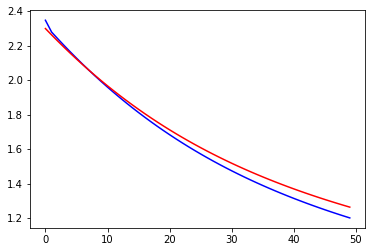

In [144]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(Scratch2dCNN.train_loss_list)), Scratch2dCNN.train_loss_list, color = "blue")
plt.plot(range(len(Scratch2dCNN.test_loss_list)), Scratch2dCNN.test_loss_list, color = "red")

まだまだ下がりそうではあるが、相当な時間がかかる為、省略。

## Skip【問題7】（アドバンス課題）LeNet
CNNで画像認識を行う際は、フィルタサイズや層の数などを１から考えるのではなく、有名な構造を利用することが一般的です。現在では実用的に使われることはありませんが、歴史的に重要なのは1998年の LeNet です。この構造を再現してMNISTに対して動かし、Accuracyを計算してください。


Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11):2278–2324, 1998.

<img src="https://cdn-ak.f.st-hatena.com/images/fotolife/a/arakan_no_boku/20170923/20170923102525.jpg">

※上記論文から引用


サブサンプリングとは現在のプーリングに相当するものです。現代風に以下のように作ってみることにします。活性化関数も当時はシグモイド関数ですが、ReLUとします。


畳み込み層　出力チャンネル数6、フィルタサイズ5×5、ストライド1  
ReLU  
最大プーリング  
畳み込み層　出力チャンネル数16、フィルタサイズ5×5、ストライド1  
ReLU  
最大プーリング  
平滑化  
全結合層　出力ノード数120  
ReLU  
全結合層　出力ノード数84  
ReLU  
全結合層　出力ノード数10  
ソフトマックス関数

## 【問題8】（アドバンス課題）有名な画像認識モデルの調査

CNNの代表的な構造としてははAlexNet(2012)、VGG16(2014)などがあります。こういったものはフレームワークで既に用意されていることも多いです。


どういったものがあるか簡単に調べてまとめてください。名前だけでも見ておくと良いでしょう。


《参考》

Applications - Keras Documentation


## ＜LeNet＞
1998年に提案された、現Facebook AI ResearchのYann LeCun先生によるCNNの元祖となるネットワーク。畳込み層とプーリング層を交互に重ねたネットワークで、この時点ですでに現在使われているアーキテクチャとほぼ同じ形になっている。活性化関数がシグモイド関数な点、プーリング層がMaxプーリングではなくサブサンプリングで縮小している点などが特徴。

<img src="https://cdn-ak.f.st-hatena.com/images/fotolife/a/arakan_no_boku/20170923/20170923102525.jpg">

## ＜AlexNet＞
2012年のImageNetを使った画像認識コンペILSVRCで圧倒的な成績を残し、ディープラーニングの火付け役となった。

畳み込み層とプーリング層、そして正規化層と呼ばれる局所的正規化(LRN ― Local Response Normalization)を行う層を重ねた14層のネットワーク。活性化関数はReLUで、Dropoutを用いているのが特徴。他にもData Augmentationなども行っていて、現在使われているCNNでの主要な手法がこの時点ですでに活用されている。

<img src="https://qiita-user-contents.imgix.net/https%3A%2F%2Fqiita-image-store.s3.amazonaws.com%2F0%2F209049%2Fbbf90731-67c0-2d75-f64e-1272ddebf653.jpeg?ixlib=rb-1.2.2&auto=format&gif-q=60&q=75&w=1400&fit=max&s=ac4d8631c8b11fdd1825827b2c7c6947">

## ＜GoogLeNet＞(Inception-v3)
2014年のコンペで1位になったアーキテクチャ。このアーキテクチャは通常の入力層から出力層まで縦一直線な構造ではなく、インセプション構造と呼ばれる横にも層が広がる構造をしている。このため、Inceptionモデルとも呼ばれる。


<img src="https://qiita-user-contents.imgix.net/https%3A%2F%2Fqiita-image-store.s3.ap-northeast-1.amazonaws.com%2F0%2F209705%2F67f98213-a8ff-de52-2d7e-18a3ef37cdd2.png?ixlib=rb-1.2.2&auto=format&gif-q=60&q=75&s=ad62bf7055736fceb31f9d616d9fcb56">

## ＜VGG＞
2014年のILSVRCで2位になった、オックスフォード大学のVGGチームのネットワーク。AlexNetをより深くした、畳み込み層とプーリング層から成るどノーマルなCNNで、重みがある層(畳み込み層や全結合層)を16層、もしくは19層重ねたもの。それぞれVGG16やVGG19と呼ばれる。

<img src="https://img2018.cnblogs.com/blog/583030/201909/583030-20190912164331595-1580838215.png">

[rain]:http://2.bp.blogspot.com/-GkAkf2Df5JY/VgJ6ytq6XAI/AAAAAAAAOWE/Vx5l-MeObbo/s1600/rain.gif

## ＜ResNet＞
Microsoft(当時)のKaiming He氏による、2015年のILSVRCで優勝したネットワーク。それまでのネットワークでは層を深くしすぎると性能が落ちるという問題があったが、それを「スキップ構造」によって解決し、152層もの深さ(前年優勝のGoogLeNetでも22層)を実現した。

スキップ構造は、ある層への入力をバイパスし層をまたいで奥の層へ入力してしまうというもので、これにより勾配の消失や発散を防止し、超多層のネットワークを実現している。

<img src="https://www.bigdata-navi.com/aidrops/wp-content/uploads/2020/03/1-198x1200.png">

## 【問題9】出力サイズとパラメータ数の計算

CNNモデルを構築する際には、全結合層に入力する段階で特徴量がいくつになっているかを事前に計算する必要があります。


また、巨大なモデルを扱うようになると、メモリや計算速度の関係でパラメータ数の計算は必須になってきます。フレームワークでは各層のパラメータ数を表示させることが可能ですが、意味を理解していなくては適切な調整が行えません。


以下の3つの畳み込み層の出力サイズとパラメータ数を計算してください。パラメータ数についてはバイアス項も考えてください。



１.  ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■

入力サイズ : 144×144, 3チャンネル  
フィルタサイズ : 3×3, 6チャンネル  
ストライド : 1  
パディング : なし  

$$
N_{h,out} =  \frac{N_{h,in}+2P_{h}-F_{h}}{S_{h}} + 1 = \frac{144+2*0-3}{1} + 1 = 142
$$


$$
N_{w,out} =  \frac{N_{w,in}+2P_{w}-F_{w}}{S_{w}} + 1 = \frac{144+2*0-3}{1} + 1 = 142
$$

以上から、出力として、142×142, 6ch　の出力マップが得られる。

パラメータ数は、  
フィルターの縦 * フィルターの横 * 入力のチャンネル数 * 出力のチャンネル数 + バイアス(1チャンネルごとに1つ)　から  
3(FH) * 3(FW) * 3(in_ch) * 6(out_ch) + 6(B) = 168コ


２.  ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■

入力サイズ : 60×60, 24チャンネル  
フィルタサイズ : 3×3, 48チャンネル  
ストライド　: 1  
パディング : なし  

$$
N_{h,out} =  \frac{N_{h,in}+2P_{h}-F_{h}}{S_{h}} + 1 = \frac{60+2*0-3}{1} + 1 = 58
$$



$$
N_{w,out} =  \frac{N_{w,in}+2P_{w}-F_{w}}{S_{w}} + 1 = \frac{60+2*0-3}{1} + 1 = 58
$$


以上から、出力として、58×58, 48ch　の出力マップが得られる。

パラメータ数は、  
フィルターの縦 * フィルターの横 * 入力のチャンネル数 * 出力のチャンネル数 + バイアス(1チャンネルごとに1つ)　から  
3(FH) * 3(FW) * 24(in_ch) * 48(out_ch) + 48(B) = 10416コ


３.  ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■

入力サイズ : 20×20, 10チャンネル  
フィルタサイズ: 3×3, 20チャンネル  
ストライド : 2  
パディング : なし  


＊最後の例は丁度良く畳み込みをすることができない場合です。フレームワークでは余ったピクセルを見ないという処理が行われることがあるので、  
その場合を考えて計算してください。端が欠けてしまうので、こういった設定は好ましくないという例です。

$$
N_{h,out} =  \frac{N_{h,in}+2P_{h}-F_{h}}{S_{h}} + 1 = \frac{20+2*0-3}{2} + 1 ≒ 9　(切り捨て)
$$



$$
N_{w,out} =  \frac{N_{w,in}+2P_{w}-F_{w}}{S_{w}} + 1 = \frac{20+2*0-3}{2} + 1 ≒ 9　(切り捨て)
$$

以上から、出力として、9×9, 20ch　の出力マップが得られる。

パラメータ数は、  
フィルターの縦 * フィルターの横 * 入力のチャンネル数 * 出力のチャンネル数 + バイアス(1チャンネルごとに1つ)　から  
3(FH) * 3(FW) * 10(in_ch) * 20(out_ch) + 20(B) = 1820コ

# 【問題10】（アドバンス課題）フィルタサイズに関する調査
畳み込み層にはフィルタサイズというハイパーパラメータがありますが、2次元畳み込み層において現在では3×3と1×1の使用が大半です。以下のそれぞれを調べたり、自分なりに考えて説明してください。


7×7などの大きめのものではなく、3×3のフィルタが一般的に使われる理由
高さや幅方向を持たない1×1のフィルタの効果

①CNNでは、MaxPoolingが主に使われるため、フィルターサイズを7×7などの大きな値にすると、大域最大値で丸められるため、局所的な特徴が捨てられてしまう。  

②例えば、(縦, 横, チャンネル)=(100, 100, 32)の層を、3×3の畳み込み層を用いて(100,100,64)にすることを考えます。

<img src="https://miro.medium.com/max/1400/1*YBaxCyPtG8knAGWWNcaiVg.png">

この時、上図のようにストレートに畳み込み層を実装すると、必要な変数は3×3x32×64+64=18496個です。では次に、この2つの層の間に1×1の畳み込み層を挟んでみましょう。この時、1×1畳み込み層の出力チャンネルは32より小さくなるようにします。今回は32の半分の16とします。

<img src="https://miro.medium.com/max/1400/1*Dvly7btqkdj9jun3IK--ow.png">

すると、必要な変数は
・最初の畳み込み層:1×1x32×16+16=528
・次の畳み込み層:3×3x16×64+64=9280
・計：9808

となり、層の数は増えているにもかかわらず、元の構造からパラメータの数を半分近くまで落とすことに成功しました。このように、1×1の畳み込み層を挟むことでモデル全体のサイズを小さくできるため、計算能力が低い環境や、低電力の環境でもモデルを動かすことが可能となります。

<a href="https://medium.com/lsc-psd/%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%82%A8%E3%83%B3%E3%82%B8%E3%83%8B%E3%82%A2%E3%81%AA%E3%82%89%E7%AD%94%E3%81%88%E3%82%89%E3%82%8C%E3%81%A6%E5%BD%93%E7%84%B6%E3%81%AE4%E3%81%A4%E3%81%AE%E5%95%8F%E9%A1%8C-%E7%95%B3%E3%81%BF%E8%BE%BC%E3%81%BF%E5%B1%A4%E7%B7%A8-659809195d2" target="_blank">機械学習エンジニアなら答えられて当然の問題4問 ～畳み込み層編～  問題３</a>